In [1]:
import os
import sys
# Get the path to the current directory of the script
bins_path = "/Users/jzeng63/Desktop/CDNA/ML/HMM/TS/Bins"
sys.path.append(bins_path)

In [2]:
import pandas as pd
import numpy as np
from itertools import product
import random
import utility as utl
import matplotlib.pyplot as plt
import joblib
from pykalman import KalmanFilter
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score

In [5]:
# Load the cleaned dataset
data_cleaned = pd.read_csv('../../../Data_processing/Outputs/train.csv')

# Exclusion or inclusion only rejection samples
data_cleaned = data_cleaned.loc[data_cleaned['usubjid'].isin(data_cleaned[data_cleaned['label'] == 1]["usubjid"].unique())]
data_cleaned.dropna(inplace=True)

# Preprocess the data #['aval_AlloMap', 'aval_AlloSure', 'ady_dna']
features = ['aval_AlloMap', 'aval_AlloSure', 'ady_dna']
target = 'label'
# Group data by 'usubjid' to maintain sequence structure
grouped_data = data_cleaned.groupby('usubjid')
shuffled_df = grouped_data.sample(frac=1, random_state=42).sort_values(['usubjid', 'ady_dna'])

In [6]:
shuffled_df

,usubjid,ady_dna,avisitn,aval_AlloMap,aval_AlloSure,label
111,CDNA-SN-C-00011-S01-010,73,60,30.0,0.060403,0.0
112,CDNA-SN-C-00011-S01-010,88,91,25.0,0.036974,0.0
113,CDNA-SN-C-00011-S01-010,116,121,26.0,0.045695,0.0
114,CDNA-SN-C-00011-S01-010,144,182,28.0,0.020336,0.0
115,CDNA-SN-C-00011-S01-010,159,182,34.0,0.016161,0.0
...,...,...,...,...,...,...
26134,CDNA-SN-C-00011-S66-011,857,821,32.0,0.210610,0.0
26135,CDNA-SN-C-00011-S66-011,945,912,32.0,0.869300,0.0
26336,CDNA-SN-C-00011-S67-001,150,182,27.0,0.082151,1.0
26371,CDNA-SN-C-00011-S67-006,427,456,34.0,0.055184,1.0


In [17]:
X = shuffled_df[models["AS_AM_noptd"][3]].values

In [18]:
AS_AM_noptd = "80%train_50iter_commetrics__No__partial__AS&AM_125.pkl"
model_directory = "../models"
models = {"AS_AM_noptd":[AS_AM_noptd, "AS", 0.5, ['aval_AlloMap','aval_AlloSure', "ady_dna"]]}
model_path = os.path.join(model_directory, models["AS_AM_noptd"][0])
kf = joblib.load(model_path)

In [19]:
state_means, state_covariance = kf.filter(X)
predicted_allosure = state_means[:, 1]
predicted_labels = (predicted_allosure > 0.5).astype(int)
AS_labels = (X[:, 1] > 0.5).astype(int)

In [24]:
shuffled_df["pred_labels"] = predicted_labels
shuffled_df["AS_labels"] = AS_labels
shuffled_df["pred_AS"] = state_means[:, 1]

In [95]:
test = shuffled_df.drop_duplicates(subset = ["usubjid", "label"], keep = "first")

In [96]:
test["diff"] = test["label"] - test["pred_labels"]
test["diff_as"] = test["label"] - test["AS_labels"]

/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_35343/3526512497.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["diff"] = test["label"] - test["pred_labels"]
/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_35343/3526512497.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["diff_as"] = test["label"] - test["AS_labels"]


In [99]:
test.loc[(test["diff"] == 0) & (test["diff_as"] == -1)]

,usubjid,ady_dna,avisitn,aval_AlloMap,aval_AlloSure,label,pred_labels,AS_labels,pred_AS,diff,diff_as
5891,CDNA-SN-C-00011-S05-059,176,182,30.0,0.965088,0.0,0,1,0.472768,0.0,-1.0
9147,CDNA-SN-C-00011-S12-053,60,60,33.0,0.799537,0.0,0,1,0.373531,0.0,-1.0
13932,CDNA-SN-C-00011-S19-001,73,60,21.0,0.787474,0.0,0,1,0.438259,0.0,-1.0
21031,CDNA-SN-C-00011-S38-033,85,91,23.0,0.681063,0.0,0,1,0.230964,0.0,-1.0


In [103]:
test_one = shuffled_df.loc[shuffled_df["usubjid"] == "CDNA-SN-C-00011-S38-033"]

In [104]:
test_one

,usubjid,ady_dna,avisitn,aval_AlloMap,aval_AlloSure,label,pred_labels,AS_labels,pred_AS
21031,CDNA-SN-C-00011-S38-033,85,91,23.0,0.681063,0.0,0,1,0.230964
21032,CDNA-SN-C-00011-S38-033,120,121,27.0,0.305922,0.0,0,0,0.204087
21033,CDNA-SN-C-00011-S38-033,157,182,12.0,0.110016,0.0,0,0,0.118333
21034,CDNA-SN-C-00011-S38-033,186,182,14.0,0.128775,0.0,0,0,0.121508
21035,CDNA-SN-C-00011-S38-033,218,182,22.0,0.153496,0.0,0,0,0.155689
21036,CDNA-SN-C-00011-S38-033,246,273,29.0,0.247834,0.0,0,0,0.217015
21037,CDNA-SN-C-00011-S38-033,276,273,22.0,0.250631,0.0,0,0,0.228985
21038,CDNA-SN-C-00011-S38-033,365,365,33.0,1.141279,1.0,1,1,0.657397
21041,CDNA-SN-C-00011-S38-033,547,547,26.0,1.482874,0.0,1,1,1.032892
21043,CDNA-SN-C-00011-S38-033,729,730,31.0,1.471971,0.0,1,1,1.259714


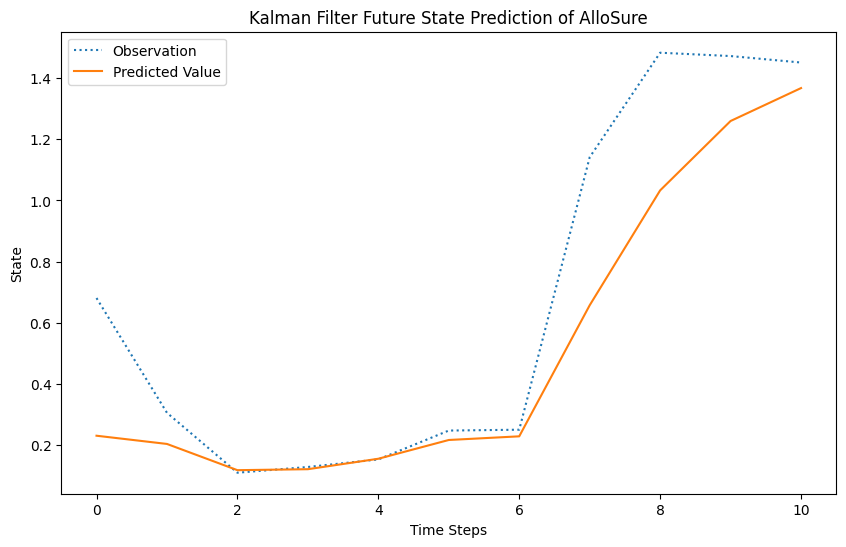

In [105]:
plt.figure(figsize=(10, 6))
plt.plot(range(test_one.shape[0]), test_one["aval_AlloSure"], label = "Observation", linestyle=':')
plt.plot(range(test_one.shape[0]), test_one["pred_AS"], label='Predicted Value')


plt.xlabel('Time Steps')
plt.ylabel('State')
plt.title('Kalman Filter Future State Prediction of AlloSure')
plt.legend()
plt.show()

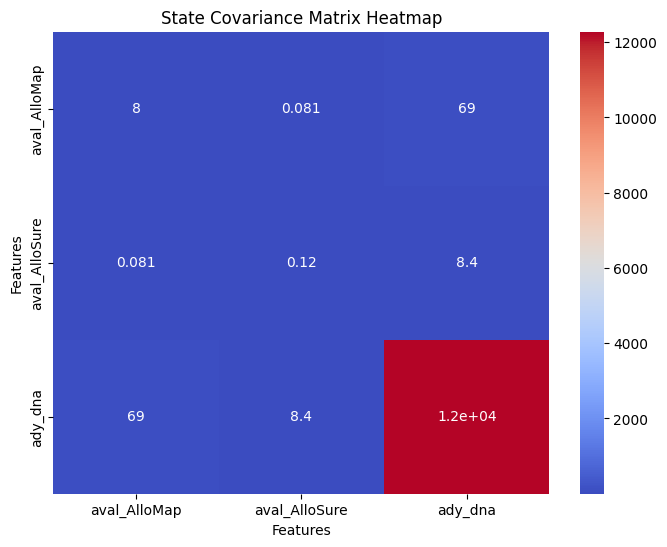

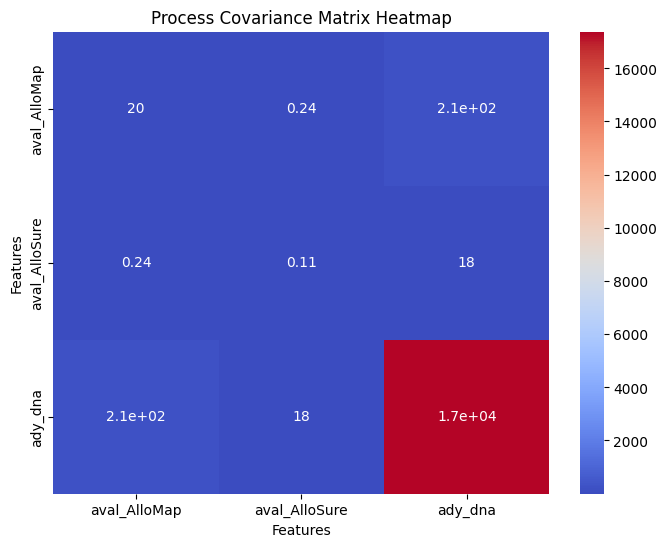

In [111]:
import seaborn as sns
state_means, state_covariance = kf.filter(X)
# Access the transition covariance matrix (Q matrix)
process_covariance_matrix = kf.transition_covariance
# P matrix is analogous to the filtered state covariances (filtered_state_covariances)
# Selecting the covariance matrix for the last time step
state_covariance_matrix = state_covariance[-1]

feature_names = ['aval_AlloMap', 'aval_AlloSure', 'ady_dna']

# Plot the State Covariance Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(state_covariance_matrix, annot=True, cmap="coolwarm", xticklabels=feature_names, yticklabels=feature_names)
plt.title("State Covariance Matrix Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

# Plot the Process Covariance Matrix (Q) Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(process_covariance_matrix, annot=True, cmap="coolwarm", xticklabels=feature_names, yticklabels=feature_names)
plt.title("Process Covariance Matrix Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

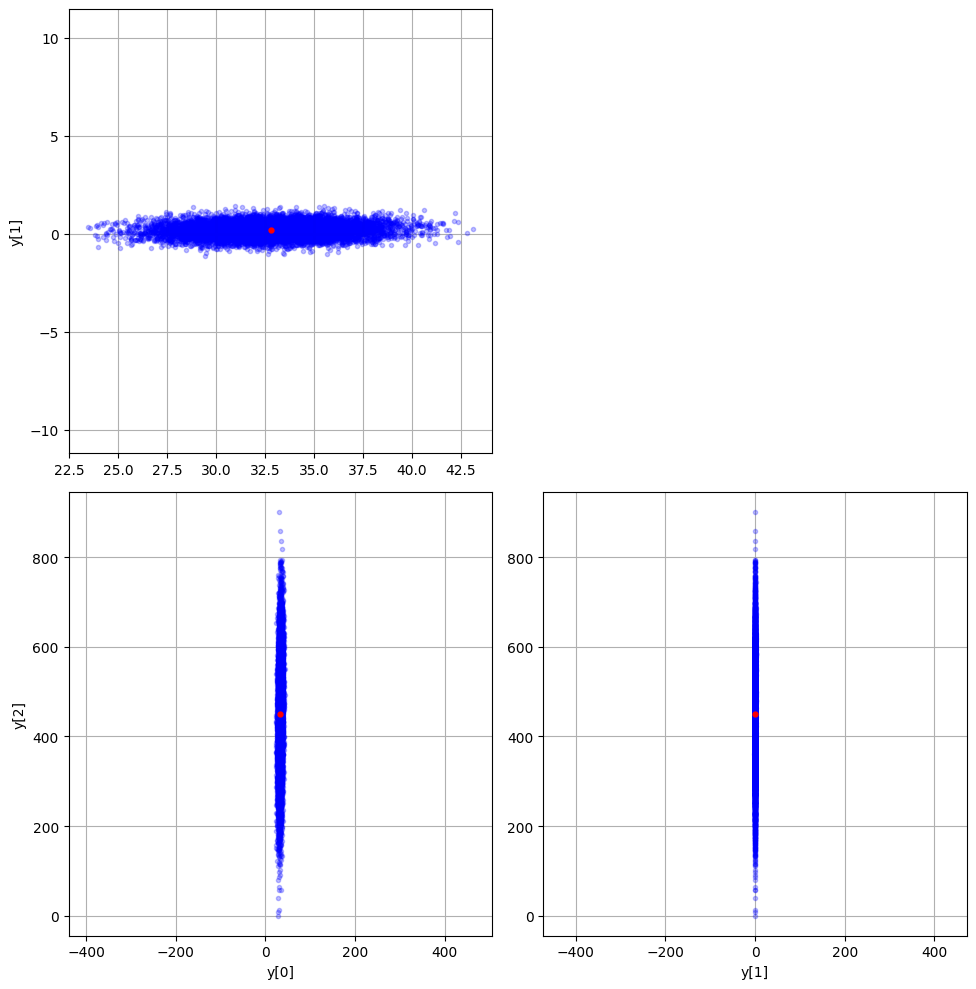

In [113]:
# Take the last state mean and covariance for generating samples
mu = state_means[-1]  # Final filtered state mean (as mu in the original code)
covariance_matrix = state_covariance[-1]  # Final state covariance matrix (as r in the original code)

# Generate the random samples using the final state mean and covariance matrix
rng = np.random.default_rng()
y = rng.multivariate_normal(mu, covariance_matrix, size = 10000)

# Plot various projections of the samples
plt.figure(figsize=(10, 10))

# Plot y[0] vs y[1]
plt.subplot(2, 2, 1)
plt.plot(y[:, 0], y[:, 1], 'b.', alpha=0.25)
plt.plot(mu[0], mu[1], 'ro', ms=3.5)
plt.ylabel('y[1]')
plt.axis('equal')
plt.grid(True)

# Plot y[0] vs y[2]
plt.subplot(2, 2, 3)
plt.plot(y[:, 0], y[:, 2], 'b.', alpha=0.25)
plt.plot(mu[0], mu[2], 'ro', ms=3.5)
plt.xlabel('y[0]')
plt.ylabel('y[2]')
plt.axis('equal')
plt.grid(True)

# Plot y[1] vs y[2]
plt.subplot(2, 2, 4)
plt.plot(y[:, 1], y[:, 2], 'b.', alpha=0.25)
plt.plot(mu[1], mu[2], 'ro', ms=3.5)
plt.xlabel('y[1]')
plt.axis('equal')
plt.grid(True)

plt.tight_layout()
plt.show()